## Assuming you've already ran 'Lineup_Merge.py' and have your progression data in a folder called 'output'

In [10]:
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Load Data Function

In [11]:


teams_list = ['LMU (CA)', 'Oregon St.', 'Gonzaga', 'Pepperdine', 'San Francisco', 
              'Portland', 'San Diego', 'Pacific', 'Santa Clara', 'Washington St.', 
              "Saint Mary's (CA)"]

def load_all_team_data(teams_list):
    """Load and merge all team progression and top lineup data"""
    # Initialize containers
    all_progression = []
    all_top_lineups = []
    
    for team in teams_list:
        # Load progression data
        prog_file = f"output/{team.replace('/', '_')}_progression.csv"  # Handle special chars
        if Path(prog_file).exists():
            prog_df = pd.read_csv(prog_file)
            prog_df['team'] = team
            all_progression.append(prog_df)
        
        # Load top lineups data
        top_file = f"output/{team.replace('/', '_')}_top_lineups.csv"
        if Path(top_file).exists():
            top_df = pd.read_csv(top_file)
            top_df['team'] = team
            all_top_lineups.append(top_df)
    
    # Combine all data
    combined_progression = pd.concat(all_progression, ignore_index=True)
    #drop 'interval' column if it exists
    if 'interval' in combined_progression.columns:
        combined_progression.drop(columns=['interval'], inplace=True)
    combined_top_lineups = pd.concat(all_top_lineups, ignore_index=True)
    
    combined_progression.fillna(0, inplace=True)
    combined_top_lineups.fillna(0, inplace=True)
    
    return combined_progression, combined_top_lineups


### Load all data

In [12]:
wcc_progression, wcc_top_lineups = load_all_team_data(teams_list)

## Lineups with more than delta = 50 minutes in any given interval

In [13]:
delta = 50

lineups_over_50_per_interval = wcc_progression[wcc_progression['minutes'] > delta][['lineup', 'team', 'interval_num', 'minutes', 'plusminus_per40']].sort_values(
    by='plusminus_per40', ascending=False
)


styled = lineups_over_50_per_interval.style.background_gradient(
    cmap = 'RdYlGn',
    subset = ['plusminus_per40']
).format(
    {
    'plusminus_per40': '{:.1f}',
    'minutes': '{:.0f}'
    }
)
display(styled)
print('Number of Lineups with over 50 minutes in an interval : ', len(lineups_over_50_per_interval))


,lineup,team,interval_num,minutes,plusminus_per40
1251,MMEE-AMAR-ESHE-MBUR-THUL,Portland,2,68,36.5
1343,MMEE-AMAR-ESHE-MBUR-THUL,Portland,3,114,23.8
1146,MMEE-AMAR-ESHE-MBUR-THUL,Portland,1,88,23.3
1814,AJAM-LSMI-SWAR-EELL-MRAD,Pacific,2,63,21.7
2481,EVIL-ATUH-JVIL-DMEN-TWAL,Washington St.,3,60,18.7
1402,MMEE-AMAR-ESHE-MBUR-THUL,Portland,4,147,17.7
951,LLEI-CFUL-EPOR-DSAN-FWER,San Francisco,2,68,14.7
171,KSHU-TBOL-CFER-AMAR-KREE,Oregon St.,1,56,13.5
298,KSHU-TBOL-CFER-AMAR-KREE,Oregon St.,4,80,11.6
2558,EVIL-ATUH-JVIL-DMEN-TWAL,Washington St.,4,56,11.4


Number of Lineups with over 50 minutes in an interval :  28


## Lineups with more than delta = 50 minutes in any given interval (sorted by interval)

In [14]:
delta = 50

lineups_over_50_per_interval = wcc_progression[wcc_progression['minutes'] > delta][['lineup', 'team', 'interval_num', 'minutes', 'plusminus_per40']].sort_values(
    by='interval_num', ascending=True
)


styled = lineups_over_50_per_interval.style.background_gradient(
    cmap = 'RdYlGn',
    subset = ['plusminus_per40']
).format(
    {
    'plusminus_per40': '{:.1f}',
    'minutes': '{:.0f}'
    }
)
display(styled)
print('Number of Lineups with over 50 minutes in an interval : ', len(lineups_over_50_per_interval))

,lineup,team,interval_num,minutes,plusminus_per40
1793,AJAM-LSMI-SWAR-EELL-MRAD,Pacific,1,71,-11.2
1146,MMEE-AMAR-ESHE-MBUR-THUL,Portland,1,88,23.3
2224,EVIL-ATUH-JVIL-TWAL-ACOV,Washington St.,1,86,-10.3
171,KSHU-TBOL-CFER-AMAR-KREE,Oregon St.,1,56,13.5
637,OMUC-MMAS-MMAS-EBRU-MHAR,Pepperdine,1,55,3.7
333,ATUR-IBET-CO'C-YEJI-MHUI,Gonzaga,1,74,10.3
1251,MMEE-AMAR-ESHE-MBUR-THUL,Portland,2,68,36.5
951,LLEI-CFUL-EPOR-DSAN-FWER,San Francisco,2,68,14.7
1814,AJAM-LSMI-SWAR-EELL-MRAD,Pacific,2,63,21.7
93,BWIL-NEVA-ZOGO-MHER-CHEI,LMU (CA),2,60,0.7


Number of Lineups with over 50 minutes in an interval :  28


## Team and Lineups with more than 50 minutes played full season

In [15]:
# First, compute total minutes per lineup
lineup_total_minutes = (
    wcc_progression.groupby(['team', 'lineup'])['minutes']
    .sum()
    .reset_index()
    .rename(columns={'minutes': 'total_minutes'})
)

# Filter to only lineups that played more than 50 minutes total
full_season_lineups = lineup_total_minutes[lineup_total_minutes['total_minutes'] > delta]

# Count lineups per team
team_full_season_counts = (
    full_season_lineups.groupby('team')
    .size()
    .reset_index(name='num_lineups_over_50')
    .sort_values(by= 'num_lineups_over_50', ascending = True)
)

display(team_full_season_counts)
print('Average number of lineups with more than 50 minutes: ',team_full_season_counts['num_lineups_over_50'].mean().round(2))


,team,num_lineups_over_50
1,LMU (CA),3
6,Saint Mary's (CA),3
3,Pacific,4
4,Pepperdine,4
7,San Diego,4
8,San Francisco,4
0,Gonzaga,5
2,Oregon St.,5
5,Portland,5
10,Washington St.,5


Average number of lineups with more than 50 minutes:  4.55


## Each Team's Top 2 Lineups (By Plusminus-Per40)

In [16]:
# Get top 2 lineups per team by plusminus_per40_mean
top2_per_team = (
    wcc_top_lineups
    .sort_values(['team', 'plusminus_per40'], ascending=[True, False])
    .groupby('team')
    .head(2)
    [['team', 'lineup', 'minutes', 'plusminus_per40']]
    
)

# Style the table
styled_top2 = top2_per_team.style.background_gradient(
    cmap='RdYlGn',
    subset=['plusminus_per40']
).format({
    'plusminus_per40': '{:.1f}',
    'minutes': '{:.0f}',
})

display(styled_top2)

,team,lineup,minutes,plusminus_per40
26,Gonzaga,ATUR-TDAL-CO'C-YEJI-ELIT,87,30.4
34,Gonzaga,ATUR-IBET-YEJI-BSAL-ELIT,27,28.1
9,LMU (CA),BWIL-NEVA-ACLA-AMAT-MHER,25,45.5
10,LMU (CA),BWIL-NEVA-MWAT-MHER-CHEI,17,16.7
21,Oregon St.,ASCH-KSHU-TBOL-CFER-KREE,33,16.8
23,Oregon St.,ASCH-KSHU-TBOL-CFER-SHEI,33,13.2
86,Pacific,AJAM-LSMI-NLOW-EELL-LGLA,60,6.0
84,Pacific,AJAM-LSMI-SWAR-EELL-MRAD,231,5.4
45,Pepperdine,MMAS-MMAS-CSOT-HFRI-MVIC,28,25.3
47,Pepperdine,OMUC-MMAS-CSOT-EBRU-MVIC,25,17.8


## Conference-Wide Analysis Pipeline

In [17]:
import numpy as np
def analyze_conference(progression_df, top_lineups_df):
    """Complete analysis pipeline for WCC"""
    # 1. Filter to only include top lineups from each team
    top_lineup_names = top_lineups_df.groupby('team')['lineup'].unique()
    progression_top = progression_df[
        progression_df.apply(lambda x: x['lineup'] in top_lineup_names[x['team']], axis=1)
    ]
    
    # 2. Calculate stability metrics with weighted stats
    def weighted_mean(df):
        return np.average(df['plusminus_per40'],weights = df['minutes'])
    def weighted_std(df):
        avg = weighted_mean(df)
        variance = np.average((df['plusminus_per40'] - avg) ** 2, weights=df['minutes'])
        return np.sqrt(variance)

    stability_stats = progression_top.groupby(['team', 'lineup'],group_keys = False).apply(
        lambda x : pd.Series({
            'minutes_sum': x['minutes'].sum(),
            'minutes_count': len(x),
            'minutes_std': x['minutes'].std(),
            'plusminus_per40_mean': weighted_mean(x),
            'plusminus_per40_std': weighted_std(x),
            'netrating_mean': np.average(x['netrating'], weights=x['minutes']),
            'netrating_std': np.sqrt(np.average((x['netrating']-np.average(x['netrating'], weights=x['minutes']))**2, 
                                              weights=x['minutes']))
        })
    ).reset_index()

    # Flatten multi-index columns
   # stability_stats.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in stability_stats.columns.values]
    
    # 3. Calculate coefficient of variation
    stability_stats['plusminus_per40_cv'] = (stability_stats['plusminus_per40_std'] / 
                                     stability_stats['plusminus_per40_mean']).abs().fillna(0)
    stability_stats['netrating_cv'] = (stability_stats['netrating_std'] /
                                     stability_stats['netrating_mean']).abs().fillna(0)
    
    
    # 4. Determine minimum sample sizes
    min_samples = []
    for (team, lineup), group in progression_top.groupby(['team', 'lineup']):
        # Calculate PROPER cumulative plusminus_per40
        cum_minutes = group['minutes'].cumsum()
        cum_plusminus = group['plusminus'].cumsum()
        cum_p40 = (cum_plusminus/cum_minutes)*40
        
        # Check for stabilization
        stabilized = False
        # Iterate through cumulative minutes and p40
        for i in range(1, len(cum_minutes)):
            if abs(cum_p40.iloc[i] - cum_p40.iloc[i-1]) < 5 and abs(cum_minutes.iloc[i]-cum_minutes.iloc[i-1])>2:  # <5 p40 change and more than 2 minutes change
                min_samples.append({
                    'team': team,
                    'lineup': lineup,
                    'stabilized_at': cum_minutes.iloc[i],
                    'stabilized_p40': cum_p40.iloc[i],
                    'final_plusminus_per40': (group['plusminus'].sum() / group['minutes'].sum()) * 40,
                    'total_minutes': cum_minutes.iloc[-1]
                })
                stabilized = True
                #print(f"Stabilized: {team} - {lineup} at {cum_minutes.iloc[i]} minutes with net rating {cum_p40.iloc[-1]}")
                break
        '''        
        if not stabilized:
            min_samples.append({
                'team': team,
                'lineup': lineup,
                'stabilized_at': cum_minutes.iloc[-1],
                'final_plusminus_per40': (group['plusminus'].sum() / group['minutes'].sum()) * 40,
                'total_minutes': cum_minutes.iloc[-1]
            })
        '''
            
    
        min_samples_df = pd.DataFrame(min_samples)
    
    return stability_stats, min_samples_df



## Run analysis pipeline - Min_Samples Table

In [18]:
stability_stats, min_samples = analyze_conference(wcc_progression, wcc_top_lineups)
numerical_cols = stability_stats.select_dtypes(include=['float64']).columns
stability_stats[numerical_cols] = stability_stats[numerical_cols].round(2)

numerical_cols = min_samples.select_dtypes(include=['float64']).columns
min_samples[numerical_cols] = min_samples[numerical_cols].round(2)
display(min_samples)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:578: RuntimeWarning: invalid value encountered in multiply
  avg = avg_as_array = np.multiply(a, wgt,
/var/folders/qh/zhr4gq8s5px2ff46zwfdk90hy3y30j/T/ipykernel_15479/1993265219.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stability_stats = progression_top.groupby(['team', 'lineup'],group_keys = False).apply(


,team,lineup,stabilized_at,stabilized_p40,final_plusminus_per40,total_minutes
0,Gonzaga,ATUR-CO'C-YEJI-ELIT-MHUI,94.29,14.42,14.42,94.29
1,Gonzaga,ATUR-IBET-CO'C-MDAL-YEJI,29.65,20.24,19.11,31.40
2,Gonzaga,ATUR-IBET-CO'C-YEJI-MHUI,99.83,9.22,9.14,100.68
3,Gonzaga,ATUR-IBET-YEJI-BSAL-ELIT,27.08,28.06,28.06,27.08
4,Gonzaga,ATUR-TDAL-BSAL-ELIT-MHUI,16.85,-21.36,-8.04,29.84
...,...,...,...,...,...,...
80,Washington St.,EVIL-ATUH-CABR-TWAL-CKPE,61.42,-7.82,-5.28,75.78
81,Washington St.,EVIL-ATUH-JVIL-DMEN-TWAL,100.85,17.06,15.02,157.12
82,Washington St.,EVIL-ATUH-JVIL-TWAL-ACOV,175.83,2.05,0.65,186.04
83,Washington St.,EVIL-ATUH-JVIL-TWAL-CKPE,74.44,-5.37,-5.37,74.44


### In case you want to reference the progression stats

In [19]:

display(wcc_progression)

,lineup,interval_num,possessions,minutes,plusminus_per40,netrating,plusminus,team
0,BWIL-NEVA-ACLA-ZOGO-MHER,1,33.19,21.60,-1.85,-3.01,-1,LMU (CA)
1,BWIL-NEVA-ZOGO-MHER-CHEI,1,75.96,47.28,-5.92,-9.22,-7,LMU (CA)
2,BWIL-NEVA-ACLA-AMAT-MHER,1,39.69,24.64,45.45,70.55,28,LMU (CA)
3,BWIL-NEVA-ACLA-MHER-CHEI,1,15.33,9.21,4.34,6.52,1,LMU (CA)
4,BWIL-MWAT-ACLA-ZOGO-AMAT,1,0.20,0.00,-inf,-500.00,-1,LMU (CA)
...,...,...,...,...,...,...,...,...
2974,JHUN-MENN-ASHO-EFOY-ECLA,4,2.83,1.75,68.57,106.01,3,Saint Mary's (CA)
2975,JHUN-KJOH-ASHO-EFOY-MAFE,4,8.60,4.62,-17.32,-23.26,-2,Saint Mary's (CA)
2976,MHAS-MJON-KJOH-ASHO-MAFE,4,5.96,2.65,90.57,100.59,6,Saint Mary's (CA)
2977,MHAS-JHUN-EFOY-MAFE-ECLA,4,7.43,5.25,15.24,26.93,2,Saint Mary's (CA)


### In case you want to reference top_lineup stats

In [20]:
display(wcc_top_lineups)

,lineup,possessions,minutes,plusminus,plusminus_per40,netrating,offrating,defrating,team
0,BWIL-NEVA-ACLA-MHER-CHEI,496.88,317.64,-39,-4.91,-7.85,89.96,97.81,LMU (CA)
1,BWIL-NEVA-ZOGO-MHER-CHEI,310.70,188.91,-9,-1.91,-2.90,93.02,95.91,LMU (CA)
2,BWIL-NEVA-ACLA-ASIT-CHEI,121.95,69.56,-26,-14.95,-21.32,80.36,101.68,LMU (CA)
3,BWIL-NEVA-ACLA-MHER-ASIT,72.34,44.39,3,2.70,4.15,89.85,85.71,LMU (CA)
4,BWIL-NEVA-ZOGO-ASIT-CHEI,65.19,37.79,13,13.76,19.94,105.84,85.90,LMU (CA)
...,...,...,...,...,...,...,...,...,...
127,JHUN-ZAOK-KJOH-ASHO-EFOY,36.29,22.57,11,19.49,30.31,115.74,85.43,Saint Mary's (CA)
128,MJON-ZAOK-KJOH-ASHO-ECLA,33.34,20.55,-18,-35.04,-53.98,65.98,119.97,Saint Mary's (CA)
129,MJON-ZAOK-KJOH-AKUR-EFOY,31.86,17.73,1,2.26,3.14,106.72,103.58,Saint Mary's (CA)
130,MHAS-MJON-ZAOK-KJOH-EFOY,28.85,15.28,-12,-31.41,-41.59,72.78,114.37,Saint Mary's (CA)


### Let's Look at lineups stabilized with at least 35 minutes and the DIFF between stabilized p40 and final_p40

In [21]:
min_samples35 = min_samples[min_samples['stabilized_at']>35]
min_samples35['p40_diff'] = min_samples35['final_plusminus_per40'] - min_samples35['stabilized_p40']
min_samples35['p40_diff'] = min_samples35['p40_diff'].round(2)
display(min_samples35.sort_values(by='total_minutes',ascending = False))



/var/folders/qh/zhr4gq8s5px2ff46zwfdk90hy3y30j/T/ipykernel_15479/568391503.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  min_samples35['p40_diff'] = min_samples35['final_plusminus_per40'] - min_samples35['stabilized_p40']
/var/folders/qh/zhr4gq8s5px2ff46zwfdk90hy3y30j/T/ipykernel_15479/568391503.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  min_samples35['p40_diff'] = min_samples35['p40_diff'].round(2)


,team,lineup,stabilized_at,stabilized_p40,final_plusminus_per40,total_minutes,p40_diff
41,Portland,MMEE-AMAR-ESHE-MBUR-THUL,269.88,26.83,23.62,416.59,-3.21
21,Oregon St.,KSHU-TBOL-CFER-AMAR-KREE,269.14,-2.38,0.80,348.67,3.18
7,LMU (CA),BWIL-NEVA-ACLA-MHER-CHEI,317.64,-4.91,-4.91,317.64,0.00
27,Pacific,AJAM-LSMI-SWAR-EELL-MRAD,174.58,4.35,5.37,230.88,1.02
12,LMU (CA),BWIL-NEVA-ZOGO-MHER-CHEI,106.99,-2.24,-1.91,188.91,0.33
82,Washington St.,EVIL-ATUH-JVIL-TWAL-ACOV,175.83,2.05,0.65,186.04,-1.40
58,San Diego,ARAN-HRHO-DMOO-KHOR-TREI,173.28,-10.85,-10.85,173.28,0.00
81,Washington St.,EVIL-ATUH-JVIL-DMEN-TWAL,100.85,17.06,15.02,157.12,-2.04
34,Pepperdine,MMAS-MMAS-CSOT-EMAS-MVIC,154.07,-13.24,-13.24,154.07,0.00
74,Santa Clara,MNAR-KING-MLAT-HRAP-OPOL,51.92,-18.49,-12.56,133.71,5.93


## Stability Stats

In [22]:
display(stability_stats)

,team,lineup,minutes_sum,minutes_count,minutes_std,plusminus_per40_mean,plusminus_per40_std,netrating_mean,netrating_std,plusminus_per40_cv,netrating_cv
0,Gonzaga,ATUR-CO'C-YEJI-ELIT-MHUI,94.29,4.0,24.55,14.42,24.87,21.73,18.26,1.72,0.84
1,Gonzaga,ATUR-IBET-CO'C-MDAL-YEJI,31.40,4.0,8.09,19.11,10.92,28.63,15.65,0.57,0.55
2,Gonzaga,ATUR-IBET-CO'C-YEJI-MHUI,100.68,3.0,36.98,9.13,2.02,13.06,2.37,0.22,0.18
3,Gonzaga,ATUR-IBET-TDAL-YEJI-ELIT,28.79,3.0,7.91,26.39,18.72,42.19,29.40,0.71,0.70
4,Gonzaga,ATUR-IBET-YEJI-BSAL-ELIT,27.08,3.0,7.22,28.07,20.94,44.79,26.44,0.75,0.59
...,...,...,...,...,...,...,...,...,...,...,...
127,Washington St.,EVIL-ATUH-JVIL-TWAL-CKPE,74.44,4.0,16.68,-5.38,32.20,-8.15,42.72,5.99,5.24
128,Washington St.,EVIL-ATUH-KGAR-TWAL-ACOV,18.53,4.0,4.17,12.95,18.88,20.10,29.58,1.46,1.47
129,Washington St.,EVIL-ATUH-MALS-DMEN-TWAL,26.22,4.0,4.52,21.36,23.95,34.84,33.51,1.12,0.96
130,Washington St.,EVIL-ATUH-MALS-TWAL-ACOV,24.84,4.0,3.07,-1.61,33.72,-4.94,55.26,20.89,11.20


### In case you want to reference progression stats

In [23]:
display(wcc_progression)

,lineup,interval_num,possessions,minutes,plusminus_per40,netrating,plusminus,team
0,BWIL-NEVA-ACLA-ZOGO-MHER,1,33.19,21.60,-1.85,-3.01,-1,LMU (CA)
1,BWIL-NEVA-ZOGO-MHER-CHEI,1,75.96,47.28,-5.92,-9.22,-7,LMU (CA)
2,BWIL-NEVA-ACLA-AMAT-MHER,1,39.69,24.64,45.45,70.55,28,LMU (CA)
3,BWIL-NEVA-ACLA-MHER-CHEI,1,15.33,9.21,4.34,6.52,1,LMU (CA)
4,BWIL-MWAT-ACLA-ZOGO-AMAT,1,0.20,0.00,-inf,-500.00,-1,LMU (CA)
...,...,...,...,...,...,...,...,...
2974,JHUN-MENN-ASHO-EFOY-ECLA,4,2.83,1.75,68.57,106.01,3,Saint Mary's (CA)
2975,JHUN-KJOH-ASHO-EFOY-MAFE,4,8.60,4.62,-17.32,-23.26,-2,Saint Mary's (CA)
2976,MHAS-MJON-KJOH-ASHO-MAFE,4,5.96,2.65,90.57,100.59,6,Saint Mary's (CA)
2977,MHAS-JHUN-EFOY-MAFE-ECLA,4,7.43,5.25,15.24,26.93,2,Saint Mary's (CA)


## Visualization and Insights

In [24]:
def visualize_conference_trends(stats_df, min_samples_df,delta = 4):
    """Create conference-wide visualizations"""
    plt.figure(figsize=(12, 12))
    
    # Plot 1: Minutes Distribution by Team
    plt.subplot(2, 2, 1)
    sns.boxplot(data=stats_df, x='team', y='minutes_sum')
    plt.title('Total Minutes Distribution')
    plt.xticks(rotation=90)
    plt.ylabel('Total Minutes')
    
    # Plot 2: Stability vs Performance
    plt.subplot(2, 2, 3)
    # Calculate IQR for filtering outliers
    q1 = stats_df['plusminus_per40_cv'].quantile(0.25)
    q3 = stats_df['plusminus_per40_cv'].quantile(0.75)
    iqr = q3 - q1
    upper_bound = q3 + 5.5*iqr

    # Filter out extreme outliers
    filtered_df = stats_df[stats_df['plusminus_per40_cv'] <= upper_bound]
    print(upper_bound)

    # Create plot with filtered data
    ax2 = sns.scatterplot(data=filtered_df, 
                x='minutes_sum', 
                y='plusminus_per40_cv',
                hue='team',
                palette='tab20',
                s=100,
                alpha=0.8)
    

    # Add reference line and labels
    plt.axhline(y=8.5, color='red', linestyle='--', linewidth=1)
    plt.text(0.5, 8.55, 'Target Stability', 
            color='red', ha='center', va='bottom', 
            transform=ax2.get_yaxis_transform())

    # Add labels for remaining high CV lineups
    delta = 8.5  # Your threshold for highlighting
    for _, row in filtered_df.iterrows():
        if row['plusminus_per40_cv'] > delta:
            label = f"{row['lineup'].split('-')[0:2]}-{int(row['minutes_sum'])}"  # Just first initial
            ax2.text(
                row['minutes_sum'] + 0.5,  # Smaller offset
                row['plusminus_per40_cv'] + 0.02,  # Smaller offset
                label,
                fontsize=8,
                alpha=0.92
            )
    # Improve plot aesthetics
    plt.title('Performance Stability (Outliers Removed)', pad=20)
    plt.xlabel('Total Minutes Played')
    plt.ylabel('Plus-Minus per 40 CV')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

    # Set reasonable axis limits
    plt.ylim(0, min(16, filtered_df['plusminus_per40_cv'].max() * 17.1))
    plt.xlim(0, filtered_df['minutes_sum'].max() * .75)




    # Plot 3: Stabilization Minutes
    plt.subplot(2, 2, 2)
    sns.boxplot(data=min_samples_df, x='team', y='stabilized_at')
    plt.title('Minutes Until Stabilization')
    plt.xticks(rotation=90)
    plt.ylabel('Minutes')
    
    plt.tight_layout()
    plt.show()


### Vizualize Results

17.3975


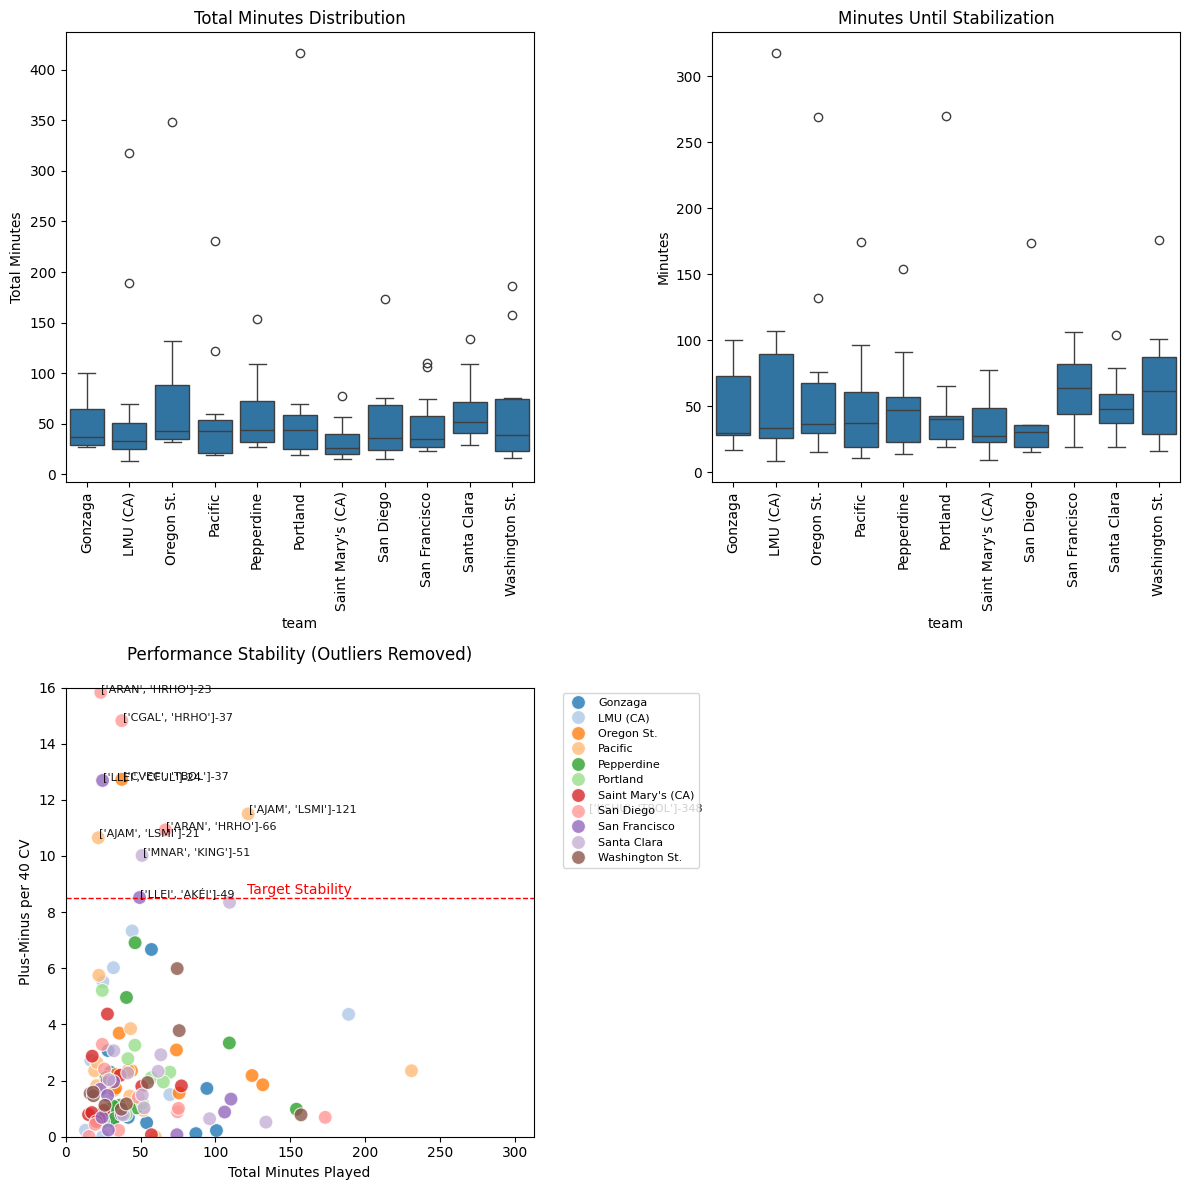

In [25]:

# Visualize results
visualize_conference_trends(stability_stats, min_samples)

## Generate Key Insights

In [26]:
def generate_wcc_insights(stats_df, min_samples_df):
    """Print actionable conference insights"""
    # Conference averages
    # Calculate without extreme values
    q1 = stats_df['plusminus_per40_cv'].quantile(0.25)
    q3 = stats_df['plusminus_per40_cv'].quantile(0.75)
    iqr = q3 - q1
    filtered = stats_df[stats_df['plusminus_per40_cv'] <= (q3 + 1.5*iqr)]
    #print(filtered['plusminus_per40_cv'].median())


    avg_stabilization = min_samples_df['stabilized_at'].median()
    avg_cv = filtered['plusminus_per40_cv'].median()

    print(f"=== WCC Conference Insights ===\n")
    print(f"1. Lineups typically stabilize after {avg_stabilization:.0f} minutes")
    print(f"   - Median coefficient of variation: {avg_cv:.2f}")
    
    # Team rankings
    team_stability = filtered.groupby('team')['plusminus_per40_cv'].mean().sort_values()
    print("\n2. Teams by lineup stability (lower CV is better):")
    print(team_stability.round(2))
    
    # Sample size recommendations
    print("\n3. Evaluation guidelines:")
    print("   - <30 minutes: Insufficient sample")
    print("   - 30-100 minutes: Preliminary assessment")
    print("   - 100+ minutes: Reliable evaluation")



In [27]:
generate_wcc_insights(stability_stats, min_samples)

=== WCC Conference Insights ===

1. Lineups typically stabilize after 38 minutes
   - Median coefficient of variation: 1.50

2. Teams by lineup stability (lower CV is better):
team
San Francisco        1.01
San Diego            1.15
Saint Mary's (CA)    1.57
Gonzaga              1.60
Santa Clara          1.71
Washington St.       2.03
Portland             2.04
Pacific              2.23
Oregon St.           2.27
Pepperdine           2.32
LMU (CA)             2.32
Name: plusminus_per40_cv, dtype: float64

3. Evaluation guidelines:
   - <30 minutes: Insufficient sample
   - 30-100 minutes: Preliminary assessment
   - 100+ minutes: Reliable evaluation


## "Use" Actionable Insights

In [28]:
#lineups with more than 53 minutes played full season sorted by plusminus_per40

lineups_over_50_full_season = stability_stats[(stability_stats['minutes_sum'] > 38) & (stability_stats['plusminus_per40_cv'] < 4)][['lineup', 'team', 'minutes_sum', 'plusminus_per40_mean','plusminus_per40_cv']]
lineups_over_50_full_season_sorted = lineups_over_50_full_season.sort_values(by='plusminus_per40_mean', ascending=False)
styled_full_season_sorted = lineups_over_50_full_season_sorted.style.background_gradient(
    cmap='RdYlGn',
    subset=['plusminus_per40_mean']
). format({
    'plusminus_per40_mean': '{:.1f}',
    'minutes_sum': '{:.0f}',
    'plusminus_per40_cv': '{:.1f}'
})
display(styled_full_season_sorted)


,lineup,team,minutes_sum,plusminus_per40_mean,plusminus_per40_cv
70,RMOG-AMAR-ESHE-MBUR-LSPE,Portland,40,48.6,0.8
7,ATUR-TDAL-CO'C-YEJI-ELIT,Gonzaga,87,30.4,0.1
62,MMEE-AMAR-ESHE-MBUR-THUL,Portland,417,23.6,0.3
119,MNAR-MLAT-MCUR-AGOO-OPOL,Santa Clara,39,22.9,0.8
71,RMOG-AMAR-ESHE-MBUR-THUL,Portland,51,20.2,1.2
5,ATUR-IBET-YEJI-ELIT-MHUI,Gonzaga,54,20.0,0.5
73,JHUN-MJON-ZAOK-KJOH-ASHO,Saint Mary's (CA),57,17.5,0.1
110,MNAR-KING-HRAP-AGOO-OPOL,Santa Clara,51,17.2,1.5
86,ARAN-HRHO-JRHO-KHOR-TREI,San Diego,48,15.7,1.4
104,LLEI-CFUL-EPOR-DSAN-FWER,San Francisco,74,15.1,0.1


## Lastly, just for fun, let's look at team combo pairs

In [29]:
all_team_pairs = []

for team, group in stability_stats.groupby('team'):
    # Step 1: Get top 2 lineups by minutes for this team
    top_2_lineups = (
        group.sort_values('minutes_sum', ascending=False)
        .head(2)['lineup'].tolist()
    )
    top_2_data = group[group['lineup'].isin(top_2_lineups)]

    # Step 2: Get players in top 2 lineups (ordered, deduped)
    top_players_ordered = []
    for lu in top_2_lineups:
        top_players_ordered += lu.split('-')
    top_players_ordered = list(dict.fromkeys(top_players_ordered))

    # Step 3: Build player pair combos for all top 2 lineups
    player_combos = []
    for _, row in top_2_data.iterrows():
        players = row['lineup'].split('-')
        for i in range(len(players)):
            for j in range(i+1, len(players)):
                player_combos.append({
                    'team': team,
                    'player1': players[i],
                    'player2': players[j],
                    'plusminus_per40': row['plusminus_per40_mean'],
                    'minutes': row['minutes_sum']
                })
    combo_df = pd.DataFrame(player_combos)
    if combo_df.empty:
        continue

    # Step 4: Aggregate across all appearances (mean plusminus, sum minutes)
    top_pairs = (
        combo_df.groupby(['team', 'player1', 'player2'])
        .agg({'plusminus_per40': 'mean', 'minutes': 'sum'})
        .reset_index()
    )

    # Step 5: Filter to pairs where both players are in top 2 lineups
    filtered_pairs = top_pairs[
        top_pairs['player1'].isin(top_players_ordered) &
        top_pairs['player2'].isin(top_players_ordered)
    ].copy()

    # Step 6: Sort by player1’s appearance order
    filtered_pairs['player1'] = pd.Categorical(filtered_pairs['player1'],
                                               categories=top_players_ordered,
                                               ordered=True)
    filtered_pairs = filtered_pairs.sort_values(['player1', 'minutes'], ascending=[True, False])

    all_team_pairs.append(filtered_pairs)

# Combine all teams
final_pairs = pd.concat(all_team_pairs, ignore_index=True)

# Style and display
styled_pairs = final_pairs.style.background_gradient(
    cmap='RdYlGn',
    subset=['plusminus_per40']
).format({
    'plusminus_per40': '{:.1f}',
    'minutes': '{:.0f}',
})

display(styled_pairs)

,team,player1,player2,plusminus_per40,minutes
0,Gonzaga,ATUR,CO'C,11.8,195
1,Gonzaga,ATUR,MHUI,11.8,195
2,Gonzaga,ATUR,YEJI,11.8,195
3,Gonzaga,ATUR,IBET,9.1,101
4,Gonzaga,ATUR,ELIT,14.4,94
5,Gonzaga,IBET,CO'C,9.1,101
6,Gonzaga,IBET,MHUI,9.1,101
7,Gonzaga,IBET,YEJI,9.1,101
8,Gonzaga,CO'C,MHUI,11.8,195
9,Gonzaga,CO'C,YEJI,11.8,195


## Save Results

In [30]:

stability_stats.to_csv('output/wcc_stability_stats.csv', index=False)
min_samples.to_csv('output/wcc_min_samples.csv', index=False)